### Unconditional density estmation
An example of unconditional density estimation with various flow architectures, using the "two moons" distribution.

### Imports

In [30]:
import jax
import jax.numpy as jnp
from jax import random
from flowjax.flows import CouplingFlow, MaskedAutoregressiveFlow
from flowjax.bijections.parameterised import Affine, RationalQuadraticSpline
from flowjax.train_utils import train_flow
from flowjax.distributions import Normal
import matplotlib.pyplot as plt
from sklearn import datasets, preprocessing


### Generate data

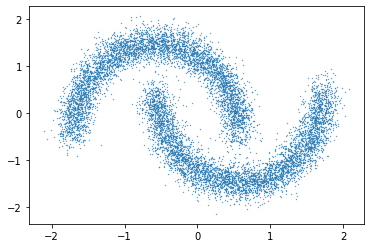

In [12]:
n_samples = 10000
x, _ = datasets.make_moons(n_samples=n_samples, noise=.1)
x = preprocessing.StandardScaler().fit_transform(x)
x = jnp.array(x)
plt.scatter(x[:, 0], x[:, 1], s=0.1)

### Create flows
Here we show how to create flows with two of the most common architectures, coupling flows (see e.g. [RealNVP](https://arxiv.org/abs/1605.08803)), and [masked autoregressive flows](https://arxiv.org/abs/1705.07057). Here we use `Affine` and [`RationalQuadraticSpline`](https://arxiv.org/abs/1906.04032) bijections.

In [13]:
key, flow_key = random.split(random.PRNGKey(1)) 
base_dist = Normal(x.shape[1])

flows = {
    "Affine Coupling": CouplingFlow(flow_key, base_dist, Affine()),
    "Spline Coupling": CouplingFlow(flow_key, base_dist, RationalQuadraticSpline(K=8, B=3)),
    "Affine Masked Autoregressive": MaskedAutoregressiveFlow(flow_key, base_dist, Affine()),
    "Spline Masked Autoregressive": MaskedAutoregressiveFlow(flow_key, base_dist, RationalQuadraticSpline(K=8, B=3)),
}

100%|██████████| 50/50 [00:22<00:00,  2.24it/s, train=1.92, val=1.91]


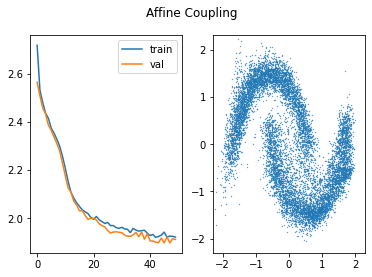

 58%|█████▊    | 29/50 [01:09<00:50,  2.39s/it, train=1.87, val=1.9] 

Max patience reached.


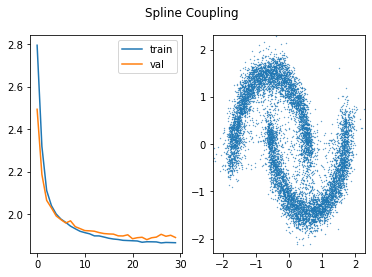

100%|██████████| 50/50 [00:29<00:00,  1.71it/s, train=2.06, val=2.05]


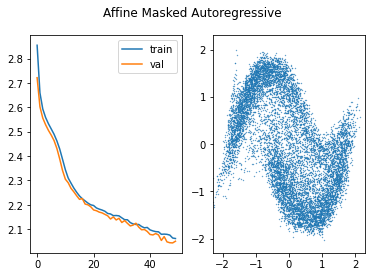

 84%|████████▍ | 42/50 [01:34<00:17,  2.25s/it, train=1.87, val=1.86]

Max patience reached.


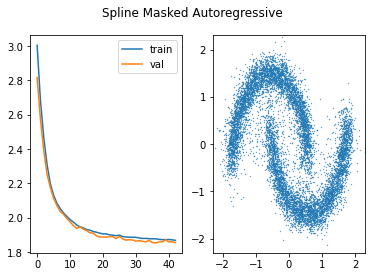

In [14]:

for flow_name, flow in flows.items():
    key, subkey = random.split(key)
    flow, losses = train_flow(subkey, flow, x)

    key, subkey = random.split(key)
    x_samples = flow.sample(key, n=10000)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(flow_name)

    for k, v in losses.items():
        ax1.plot(v, label=k)
    ax1.legend()

    ax2.scatter(x_samples[:, 0], x_samples[:, 1], s=0.1)
    lims = (-2.3, 2.3)
    ax2.set_xlim(*lims)
    ax2.set_ylim(*lims)
    plt.show()


### Density estimation
We can evaluate the probability of arbitrary points

In [18]:
five_points = jnp.linspace(0, 1, num=10).reshape((5,2))
flow.log_prob(five_points)

DeviceArray([-4.8154297, -3.0478077, -1.0428933, -4.6546025, -8.288247 ],            dtype=float32)

### Accessing the bijection
We can access the bijection and transform specific points if desired.

In [24]:
x = jnp.ones(2)
y = flow.bijection.transform(x)
x_reconstructed = flow.bijection.inverse(y)
print("Original ", x)
print("Transformed", y)
print("Inverted", x_reconstructed)

Original  [1. 1.]
Transformed [1.7348617 2.2763524]
Inverted [1.0000107 1.       ]


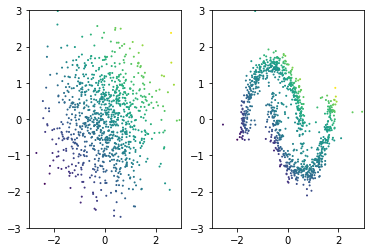

In [29]:
base_dist_samps = flow.base_dist.sample(key, n=1000)
transformed_samps = jax.vmap(flow.bijection.inverse)(base_dist_samps)
color = base_dist_samps.sum(axis=1)

fig, axs = plt.subplots(ncols=2)
axs[0].scatter(base_dist_samps[:, 0], base_dist_samps[:, 1], c=color, s=1)
axs[1].scatter(transformed_samps[:, 0], transformed_samps[:, 1], c=color, s=1)

for ax in axs:
    ax.set_xlim((-3, 3))
    ax.set_ylim((-3, 3))
